In [1]:
import torch

print("✅ CUDA 사용 가능:", torch.cuda.is_available())
print("🖥️ GPU 이름:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")
print("💡 PyTorch 버전:", torch.__version__)


✅ CUDA 사용 가능: True
🖥️ GPU 이름: NVIDIA GeForce RTX 3070 Ti Laptop GPU
💡 PyTorch 버전: 2.4.1+cu121


In [5]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from sklearn.metrics import f1_score
import numpy as np
import torch
import os
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader
from torchvision import transforms
import torch
import torch.nn as nn
import timm  # pip install timm
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
import pandas as pd
from PIL import Image
import torch
from torchvision import transforms
from sklearn.metrics import accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

c:\Users\main\miniconda3\envs\PoseDetect-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# CNN 모델 구성

In [6]:


# 4. Dataset 클래스 정의 (예시)
class PostureDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.data = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = os.path.join(self.image_dir, row["filename"])
        image = Image.open(image_path).convert("RGB")
        label = row["class_id"]
        if self.transform:
            image = self.transform(image)
        return image, label



In [7]:


class EarlyStopping:
    def __init__(self, patience=30, delta=0.0, checkpoint_path='checkpoint.pt'):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.checkpoint_path = checkpoint_path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f"🟡 EarlyStopping counter: {self.counter} / {self.patience}")
            if self.counter >= self.patience:
                print("🛑 EarlyStopping triggered! Stopping training.")
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        """Validation loss가 개선될 때만 모델 저장"""
        torch.save(model.state_dict(), self.checkpoint_path)
        print(f"✅ Model saved to {self.checkpoint_path}")


In [8]:


# CSV 불러오기
# 1. CSV 파일 불러오기
train_df = pd.read_csv("dataset-modification/train_pose_parsed.csv")[["filename", "class_id"]]
valid_df = pd.read_csv("dataset-modification/valid_pose_parsed.csv")[["filename", "class_id"]]

df_train_grouped = train_df.groupby("filename")["class_id"].min().reset_index()
df_valid_grouped = valid_df.groupby("filename")["class_id"].min().reset_index()

train_df = df_train_grouped
valid_df = df_valid_grouped

# 필요한 컬럼만 사용
# df = df[["filename", "class_id"]]

# # train/val 나누기
# train_df, val_df = train_test_split(df, stratify=df["class_id"], test_size=0.2, random_state=42)
# df["class_id"].value_counts()

class_weights = compute_class_weight('balanced', classes=[0, 1], y=train_df["class_id"])
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

In [9]:


# 전처리 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# 이미지 경로 정의
train_image_dir = "dataset-modification/train-visualized/images/"
valid_image_dir = "dataset-modification/valid/images/"

# Dataset 생성
train_dataset = PostureDataset(train_df, train_image_dir, transform)
val_dataset = PostureDataset(valid_df, valid_image_dir, transform)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
print("Train 클래스 분포:\n", train_df["class_id"].value_counts())
print("Valid 클래스 분포:\n", valid_df["class_id"].value_counts())
print("Class weights:", class_weights_tensor)


Train 클래스 분포:
 0    1586
1     995
Name: class_id, dtype: int64
Valid 클래스 분포:
 0    408
1    292
Name: class_id, dtype: int64
Class weights: tensor([0.8137, 1.2970])


## 데이터 증강

In [10]:


train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.95, 1.05)),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
train_dataset = PostureDataset(train_df, train_image_dir, transform=train_transform)
val_dataset = PostureDataset(valid_df, valid_image_dir, transform=val_transform)


In [ ]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=1)
in_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.BatchNorm1d(in_features),
    nn.Linear(in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(64, 1)
)
model = model.to(device)


In [12]:


criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor[1].to(device))  # class_weight
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train_epoch(loader, is_train=True):
    model.train() if is_train else model.eval()
    running_loss = 0.0
    preds, labels = [], []

    for images, targets in loader:
        images = images.to(device)
        targets = targets.float().to(device).unsqueeze(1)

        if is_train:
            optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, targets)

        if is_train:
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * images.size(0)

        preds_batch = (torch.sigmoid(outputs).detach().cpu().numpy() > 0.5).astype(int)
        targets_batch = targets.detach().cpu().numpy().astype(int)

        preds.extend(preds_batch)
        labels.extend(targets_batch)

    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)

    return running_loss / len(loader.dataset), acc, f1



## 실험

In [11]:
early_stopper = EarlyStopping(patience=30, checkpoint_path="best_model.pt")

for epoch in range(1, 101):
    train_loss, train_acc, train_f1 = train_epoch(train_loader)
    val_loss, val_acc, val_f1 = train_epoch(val_loader, is_train=False)

    print(f"📊 Epoch {epoch}: "
          f"Train Loss={train_loss:.4f}, Acc={train_acc:.4f}, F1={train_f1:.4f} | "
          f"Val Loss={val_loss:.4f}, Acc={val_acc:.4f}, F1={val_f1:.4f}")

    early_stopper(val_loss, model)
    if early_stopper.early_stop:
        print("🛑 EarlyStopping triggered! Stopping training.")
        break


📊 Epoch 1: Train Loss=0.3815, Acc=0.8628, F1=0.8322 | Val Loss=0.3957, Acc=0.8471, F1=0.8165
✅ Model saved to best_model.pt
📊 Epoch 2: Train Loss=0.2045, Acc=0.9334, F1=0.9150 | Val Loss=0.4364, Acc=0.8643, F1=0.8336
🟡 EarlyStopping counter: 1 / 30
📊 Epoch 3: Train Loss=0.1314, Acc=0.9582, F1=0.9463 | Val Loss=0.5294, Acc=0.8586, F1=0.8260
🟡 EarlyStopping counter: 2 / 30
📊 Epoch 4: Train Loss=0.1048, Acc=0.9616, F1=0.9506 | Val Loss=0.5284, Acc=0.8614, F1=0.8283
🟡 EarlyStopping counter: 3 / 30
📊 Epoch 5: Train Loss=0.0817, Acc=0.9721, F1=0.9639 | Val Loss=0.6448, Acc=0.8529, F1=0.8151
🟡 EarlyStopping counter: 4 / 30
📊 Epoch 6: Train Loss=0.0756, Acc=0.9721, F1=0.9638 | Val Loss=0.7025, Acc=0.8529, F1=0.8164
🟡 EarlyStopping counter: 5 / 30
📊 Epoch 7: Train Loss=0.0665, Acc=0.9752, F1=0.9680 | Val Loss=0.8376, Acc=0.8500, F1=0.8128
🟡 EarlyStopping counter: 6 / 30
📊 Epoch 8: Train Loss=0.0557, Acc=0.9764, F1=0.9695 | Val Loss=0.8920, Acc=0.8471, F1=0.8093
🟡 EarlyStopping counter: 7 / 30
📊

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 정의 (학습 당시와 동일하게)
model = timm.create_model('efficientnet_b0', pretrained=False, num_classes=1)
model.classifier = torch.nn.Sequential(
    torch.nn.BatchNorm1d(model.classifier.in_features),
    torch.nn.Linear(model.classifier.in_features, 1)
)
model.load_state_dict(torch.load("best_model.pt"))
model.to(device)
model.eval()


C:\Users\main\AppData\Local\Temp\ipykernel_13968\2560990639.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))


EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

## 결과 확인

### dropout 전 모델 그래프

In [ ]:
import matplotlib.pyplot as plt

# Epoch별 데이터 정의
epochs = list(range(1, 32))
train_f1 = [0.8403, 0.9235, 0.9472, 0.9575, 0.9544, 0.9680, 0.9724, 0.9695, 0.9774, 0.9666,
            0.9657, 0.9726, 0.9677, 0.9681, 0.9697, 0.9681, 0.9761, 0.9744, 0.9657, 0.9756,
            0.9766, 0.9723, 0.9806, 0.9740, 0.9762, 0.9714, 0.9801, 0.9757, 0.9767, 0.9766, 0.9761]
val_f1 = [0.8185, 0.8137, 0.8099, 0.8262, 0.8090, 0.8071, 0.8231, 0.7964, 0.8293, 0.8094,
          0.8163, 0.8134, 0.8115, 0.7964, 0.8090, 0.8014, 0.8154, 0.8082, 0.8262, 0.8270,
          0.8231, 0.8209, 0.8260, 0.8035, 0.8190, 0.8267, 0.8172, 0.8250, 0.8070, 0.8285, 0.8090]

train_loss = [0.3646, 0.1976, 0.1230, 0.1035, 0.0933, 0.0701, 0.0600, 0.0627, 0.0555, 0.0766,
              0.0688, 0.0477, 0.0587, 0.0530, 0.0578, 0.0569, 0.0553, 0.0549, 0.0686, 0.0460,
              0.0427, 0.0444, 0.0381, 0.0527, 0.0465, 0.0406, 0.0357, 0.0416, 0.0400, 0.0378, 0.0367]
val_loss = [0.3861, 0.4907, 0.5556, 0.6001, 0.5957, 0.7998, 0.7329, 0.8042, 0.9261, 0.7865,
            0.8100, 0.8704, 0.9341, 0.9997, 0.8669, 1.0277, 0.9587, 0.8603, 0.8414, 0.8535,
            0.8779, 0.9544, 0.9666, 1.0328, 0.9294, 0.9941, 1.0027, 1.0409, 1.2257, 1.1098, 1.1151]

# 그래프 그리기
plt.figure(figsize=(12, 5))

# F1-score plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_f1, label='Train F1', marker='o')
plt.plot(epochs, val_f1, label='Val F1', marker='s')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Train vs Validation F1 Score')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:


# 경로 및 파일
test_dir = "dataset-modification/test/images/"
label_csv = "dataset-modification/test_pose_parsed.csv"
model_path = "best_model.pt"

# 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# 모델 불러오기
model.load_state_dict(torch.load(model_path))
model.eval()
model.to(device)

# 라벨 CSV 로드
df = pd.read_csv(label_csv)

# 예측 및 비교
y_true, y_pred = [], []

with torch.no_grad():
    for idx, row in df.iterrows():
        fname = row["filename"]
        label = row["class_id"]

        img_path = os.path.join(test_dir, fname)
        image = Image.open(img_path).convert("RGB")
        image = transform(image).unsqueeze(0).to(device)

        output = model(image)
        prob = torch.sigmoid(output).item()
        pred = int(prob > 0.5)

        y_true.append(label)
        y_pred.append(pred)

# 평가 결과 출력
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"✅ Test Accuracy: {acc * 100:.2f}%")
print(f"✅ Test F1-score: {f1:.4f}")


C:\Users\main\AppData\Local\Temp\ipykernel_16992\116028409.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


✅ Test Accuracy: 85.26%
✅ Test F1-score: 0.8170


In [16]:
import numpy as np

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.sigmoid(outputs).squeeze()
        preds = (probs > 0.5).int().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())


In [ ]:

print("✅ Accuracy:", accuracy_score(all_labels, all_preds))
print("✅ Classification Report:\n", classification_report(all_labels, all_preds, target_names=["bad", "good"]))


✅ Accuracy: 0.8471428571428572
✅ Classification Report:
               precision    recall  f1-score   support

         bad       0.87      0.87      0.87       408
        good       0.82      0.82      0.82       292

    accuracy                           0.85       700
   macro avg       0.84      0.84      0.84       700
weighted avg       0.85      0.85      0.85       700



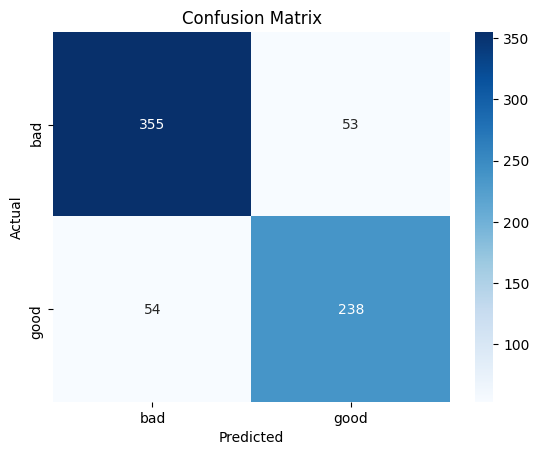

In [ ]:


cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["bad", "good"], yticklabels=["bad", "good"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


c:\Users\main\miniconda3\envs\PoseDetect-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 128202 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\main\miniconda3\envs\PoseDetect-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 128202 missing from current font.
  font.set_text(s, 0, flags=flags)


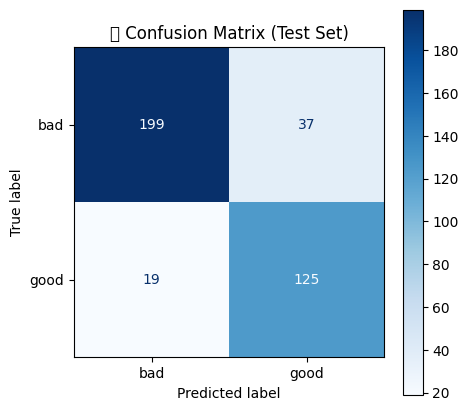

In [ ]:


# confusion matrix 생성
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["bad", "good"])

# 시각화
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, cmap="Blues", values_format="d")
plt.title("📊 Confusion Matrix (Test Set)")
plt.show()


# 하이퍼 파라미터 조정


In [13]:
def build_model(dropout_tuple=None):
    base_model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=1)
    in_features = base_model.classifier.in_features

    if dropout_tuple is None:
        classifier = nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    else:
        d1, d2 = dropout_tuple
        classifier = nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(d1),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(d2),
            nn.Linear(64, 1)
        )

    base_model.classifier = classifier
    return base_model.to(device)

def get_optimizer(opt_name, model_params, lr):
    if opt_name == "Adam":
        return optim.Adam(model_params, lr=lr)
    elif opt_name == "AdamW":
        return optim.AdamW(model_params, lr=lr)
    else:
        raise ValueError("Unsupported optimizer")


In [14]:
experiment_configs = [
    {"optimizer": "Adam", "lr": 1e-4, "dropout": (0.3, 0.2)},  # baseline
    {"optimizer": "Adam", "lr": 5e-4, "dropout": (0.0, 0.0)},
    {"optimizer": "AdamW", "lr": 1e-4, "dropout": (0.3, 0.2)},
    {"optimizer": "AdamW", "lr": 5e-4, "dropout": (0.0, 0.0)},
    {"optimizer": "AdamW", "lr": 1e-5, "dropout": (0.1, 0.0)},
    {"optimizer": "AdamW", "lr": 1e-4, "dropout": None},
]


In [ ]:
for i, config in enumerate(experiment_configs):
    print(f"\n🔬 Experiment {i+1}: {config}")

    model = build_model(dropout_tuple=config["dropout"])
    optimizer = get_optimizer(config["optimizer"], model.parameters(), config["lr"])
    criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor[1].to(device))
    early_stopper = EarlyStopping(patience=30, checkpoint_path=f"best_model_exp{i+1}.pt")

    for epoch in range(1, 101):
        train_loss, train_acc, train_f1 = train_epoch(train_loader, is_train=True)
        val_loss, val_acc, val_f1 = train_epoch(val_loader, is_train=False)

        print(f"[Exp{i+1}] Epoch {epoch}: "
              f"Train Loss={train_loss:.4f}, Acc={train_acc:.4f}, F1={train_f1:.4f} | "
              f"Val Loss={val_loss:.4f}, Acc={val_acc:.4f}, F1={val_f1:.4f}")

        early_stopper(val_loss, model)
        if early_stopper.early_stop:
            print("🛑 EarlyStopping triggered.")
            break



🔬 Experiment 1: {'optimizer': 'Adam', 'lr': 0.0001, 'dropout': (0.3, 0.2)}
[Exp1] Epoch 1: Train Loss=0.6839, Acc=0.7203, F1=0.5865 | Val Loss=0.4816, Acc=0.8314, F1=0.7951
✅ Model saved to best_model_exp1.pt
[Exp1] Epoch 2: Train Loss=0.3771, Acc=0.8718, F1=0.8414 | Val Loss=0.3780, Acc=0.8686, F1=0.8397
✅ Model saved to best_model_exp1.pt
[Exp1] Epoch 3: Train Loss=0.2002, Acc=0.9314, F1=0.9119 | Val Loss=0.4694, Acc=0.8529, F1=0.8190
🟡 EarlyStopping counter: 1 / 30
[Exp1] Epoch 4: Train Loss=0.1386, Acc=0.9543, F1=0.9410 | Val Loss=0.4680, Acc=0.8671, F1=0.8394
🟡 EarlyStopping counter: 2 / 30
[Exp1] Epoch 5: Train Loss=0.1019, Acc=0.9655, F1=0.9555 | Val Loss=0.6186, Acc=0.8529, F1=0.8183
🟡 EarlyStopping counter: 3 / 30
[Exp1] Epoch 6: Train Loss=0.0905, Acc=0.9644, F1=0.9538 | Val Loss=0.5488, Acc=0.8600, F1=0.8293
🟡 EarlyStopping counter: 4 / 30
[Exp1] Epoch 7: Train Loss=0.0870, Acc=0.9709, F1=0.9625 | Val Loss=0.6609, Acc=0.8557, F1=0.8231
🟡 EarlyStopping counter: 5 / 30
[Exp1]